# ST590 - BIG DATA IN PYTHON
# FINAL PROJECT

### AUTHORS: Xavier Genelin & Kate Sanborn

************************
### PURPOSE
The purpose of this report is to document the exploration of MRI scan data on Demented individuals and Non-demented individuals.

### MOTIVATION
Alzheimer's disease is a progressive neurological disorder that causes the brain to shrink (atrophy) and brain cells to die. Alzheimer's disease is the most common cause of dementia — a continuous decline in thinking, behavioral and social skills that affects a person's ability to function independently.

Approximately 5.8 million people in the United States age 65 and older live with Alzheimer's disease. Of those, 80\% are 75 years old and older. Out of the approximately 50 million people worldwide with dementia, between 60\% and 70\% are estimated to have Alzheimer's disease.

The early signs of the disease include forgetting recent events or conversations. As the disease progresses, a person with Alzheimer's disease will develop severe memory impairment and lose the ability to carry out everyday tasks.

Medications may temporarily improve or slow progression of symptoms. These treatments can sometimes help people with Alzheimer's disease maximize function and maintain independence for a time. However, there is no treatment that cures Alzheimer's disease or alters the disease process in the brain. In advanced stages of the disease, complications from severe loss of brain function — such as dehydration, malnutrition or infection — result in death. [[Mayo Clinic]](https://www.mayoclinic.org/diseases-conditions/alzheimers-disease/symptoms-causes/syc-20350447?msclkid=70a3e05ab46111ec921c1377f71b85d7)

Given the relatively unpredictable nature of Alzheimer's (since it is typically not detected until symptoms are displayed), it is of interest to the medical community to identify if a particular set of risk factors can be identified as relatively accurate predictors of Alzheimer-onset dementia.

Thus, we seek to explore the classification problem through identifying a set of "predictors" or risk factors associated with those identified with Alzheimer-onset dementia. Our target is Group (Demented, Nondemented, or Converted...which we reclassify as Demented).

### DATA
The data utilized was extracted from Kaggle's repository of datasets. [[kaggle]](https://www.kaggle.com/datasets/jboysen/mri-and-alzheimers?datasetId=1980&language=R) The data comes from the Open Access Series of Imaging Studies (OASIS), a project aimed at making MRI data sets of brain freely available to the scientific community. [[OASIS]](https://doi.org/10.1162/jocn.2007.19.9.1498)

For the purposes of this project, we focus on one of the MRI data sets made available through OASIS : Longitudinal MRI Data in Nondemented and Demented Older Adults.

This set consists of a collection of 150 subjects aged 60 to 96. Each subject was scanned on two or more visits, separated by at least one year for a total of 373 imaging sessions. For each subject, 3 or 4 individual T1-weighted MRI scans obtained in single scan sessions are included. The subjects are all right-handed and include both men and women. 72 of the subjects were characterized as non-demented throughout the study. 64 of the included subjects were characterized as demented at the time of their initial visits and remained so for subsequent scans, including 51 individuals with mild to moderate Alzheimer’s disease. Another 14 subjects were characterized as non-demented at the time of their initial visit and were subsequently characterized as demented at a later visit.

Even though this data is titled as "longitudinal," we consider the classification of Dementia through MRI ID as the test "unit". In the classification problem, we focus on the 'Group' variable which has levels = Demented (we include Converted with demented) & Nondemented. So, our target is binary.

#### DATA DICTIONARY
Subject.ID, MRI.ID, MR.Delay, Visit,  M.F - Gender, Hand - Handedness, Age, EDUC - Years of education, SES - Socioeconomic status as assessed by the Hollingshead Index of Social Position and classified into categories from 1 (highest status) to 5 (lowest status), 

MMSE - Mini-Mental State Examination score (range is from 0 = worst to 30 = best), CDR - Clinical Dementia Rating (0 = no dementia, 0.5 = very mild AD, 1 = mild AD, 2 = moderate AD, 3= severe)

eTIV - Estimated total intracranial volume, mm3 
nWBV - Normalized whole-brain volume, expressed as a percent of all voxels in the atlas-masked image that are labeled as gray or white matter by the automated tissue segmentation process
ASF - Atlas scaling factor (unitless). Computed scaling factor that transforms native-space brain and skull to the atlas target (i.e., the determinant of the transform matrix)

##### RELEVANT VARIABLE DEFINITIONS 
The Mini–Mental State Examination (MMSE) or Folstein test is a 30-point questionnaire that is used extensively in clinical and research settings to measure cognitive impairment. It is commonly used in medicine and allied health to screen for dementia. It is also used to estimate the severity and progression of cognitive impairment and to follow the course of cognitive changes in an individual over time. [[WIKI]](https://en.wikipedia.org/wiki/Mini_Mental_State_Examination) Any score greater than or equal to 24 points (out of 30) indicates a normal cognition. Below this, scores can indicate severe (≤9 points), moderate (10–18 points) or mild (19–23 points) cognitive impairment. The presence of purely physical problems can also interfere with interpretation if not properly noted; for example, a patient may be physically unable to hear or read instructions properly, or may have a motor deficit that affects writing and drawing skills.

The CDR in one aspect is a 5-point scale used to characterize six domains of cognitive and functional performance applicable to Alzheimer disease and related dementias: Memory, Orientation, Judgment & Problem Solving, Community Affairs, Home & Hobbies, and Personal Care. [[ADRC]](https://knightadrc.wustl.edu/professionals-clinicians/cdr-dementia-staging-instrument/)
Due to the comprehensive nature of CDR, we will consider this as our "target" variable.

The ICV measure, sometimes referred to as total intracranial volume (TIV), refers to the estimated volume of the cranial cavity as outlined by the supratentorial dura matter or cerebral contour when dura is not clearly detectable. ICV is often used in studies involved with analysis of the cerebral structure under different imaging modalities, such as Magnetic Resonance (MR), MR and Diffusion Tensor Imaging (DTI), MR and Single-photon Emission Computed Tomography (SPECT), Ultrasound and Computed Tomography (CT). ICV consistency during aging makes it a reliable tool for correction of head size variation across subjects in studies that rely on morphological features of the brain. [[PUBMED]](https://doi.org/10.1186/1471-2105-16-S7-S8)

### MODULE IMPORT

In [1]:
import numpy as np
from scipy.io import loadmat
from functools import reduce
from scipy import signal
from scipy.stats import entropy
from scipy.fft import fft, ifft
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns

from pyspark.ml.feature import SQLTransformer #sqltransformer allows us ot do all these tranf. easily
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator, BinaryClassificationEvaluator, ClusteringEvaluator
from pyspark.ml import Pipeline
from pyspark.sql.functions import isnan, when, count, col, trim
from pyspark.sql.types import BinaryType , IntegerType , StringType
import pyspark.pandas as ps

from pyspark_dist_explore import hist #need for UDF visualizations
from pyspark.ml.feature import PCA
from pyspark.ml.classification import RandomForestClassifier, DecisionTreeClassifier, LogisticRegression, GBTClassifier
from pyspark.ml.clustering import KMeans
from xgboost import XGBRegressor, plot_tree
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

#set up OS and sys vars
import os
import sys
os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable
os.environ["PYARROW_IGNORE_TIMEZONE"] = "1" #get rid of error

In [2]:
ps.options.plotting.backend = 'matplotlib'

Create a Spark instance

In [3]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

### DATA CLEANING
First we read in the longitudinal data. We will look into the existence of null values in the data and assess if we need to impute or just drop a few observations.

In [4]:
alz_pd = pd.read_csv("oasis_ALZ.csv")

print(alz_pd.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 373 entries, 0 to 372
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Subject ID  373 non-null    object 
 1   MRI ID      373 non-null    object 
 2   Group       373 non-null    object 
 3   Visit       373 non-null    int64  
 4   MR Delay    373 non-null    int64  
 5   M/F         373 non-null    object 
 6   Hand        373 non-null    object 
 7   Age         373 non-null    int64  
 8   EDUC        373 non-null    int64  
 9   SES         354 non-null    float64
 10  MMSE        371 non-null    float64
 11  CDR         373 non-null    float64
 12  eTIV        373 non-null    int64  
 13  nWBV        373 non-null    float64
 14  ASF         373 non-null    float64
dtypes: float64(5), int64(5), object(5)
memory usage: 43.8+ KB
None


In [5]:
alz_pd.head(5) #373 rows and 15 columns

,Subject ID,MRI ID,Group,Visit,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,OAS2_0001,OAS2_0001_MR1,Nondemented,1,0,M,R,87,14,2.0,27.0,0.0,1987,0.696,0.883
1,OAS2_0001,OAS2_0001_MR2,Nondemented,2,457,M,R,88,14,2.0,30.0,0.0,2004,0.681,0.876
2,OAS2_0002,OAS2_0002_MR1,Demented,1,0,M,R,75,12,NaN,23.0,0.5,1678,0.736,1.046
3,OAS2_0002,OAS2_0002_MR2,Demented,2,560,M,R,76,12,NaN,28.0,0.5,1738,0.713,1.010
4,OAS2_0002,OAS2_0002_MR3,Demented,3,1895,M,R,80,12,NaN,22.0,0.5,1698,0.701,1.034


Now we make a Spark SQL dataframe

In [6]:
alz = spark.createDataFrame(alz_pd)
alz.show(5)
#now we have a spark df

+----------+-------------+-----------+-----+--------+---+----+---+----+---+----+---+----+-----+-----+
|Subject ID|       MRI ID|      Group|Visit|MR Delay|M/F|Hand|Age|EDUC|SES|MMSE|CDR|eTIV| nWBV|  ASF|
+----------+-------------+-----------+-----+--------+---+----+---+----+---+----+---+----+-----+-----+
| OAS2_0001|OAS2_0001_MR1|Nondemented|    1|       0|  M|   R| 87|  14|2.0|27.0|0.0|1987|0.696|0.883|
| OAS2_0001|OAS2_0001_MR2|Nondemented|    2|     457|  M|   R| 88|  14|2.0|30.0|0.0|2004|0.681|0.876|
| OAS2_0002|OAS2_0002_MR1|   Demented|    1|       0|  M|   R| 75|  12|NaN|23.0|0.5|1678|0.736|1.046|
| OAS2_0002|OAS2_0002_MR2|   Demented|    2|     560|  M|   R| 76|  12|NaN|28.0|0.5|1738|0.713| 1.01|
| OAS2_0002|OAS2_0002_MR3|   Demented|    3|    1895|  M|   R| 80|  12|NaN|22.0|0.5|1698|0.701|1.034|
+----------+-------------+-----------+-----+--------+---+----+---+----+---+----+---+----+-----+-----+
only showing top 5 rows



One thing we will have to do is fix the "type" for some of these. CDR - our target variable - is read in a float, but is really ordinal. EDUC is also categorical, but is read in as an integer. 

Before we handle that, let's check out missingness.

In [7]:
### Get count of both null and missing values in pyspark
alz.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in alz.columns]).show()

+----------+------+-----+-----+--------+---+----+---+----+---+----+---+----+----+---+
|Subject ID|MRI ID|Group|Visit|MR Delay|M/F|Hand|Age|EDUC|SES|MMSE|CDR|eTIV|nWBV|ASF|
+----------+------+-----+-----+--------+---+----+---+----+---+----+---+----+----+---+
|         0|     0|    0|    0|       0|  0|   0|  0|   0| 19|   2|  0|   0|   0|  0|
+----------+------+-----+-----+--------+---+----+---+----+---+----+---+----+----+---+



Ok - it seems like we don't have too large of an issue with missingess. We just have 19 observations null for Socio-Economic Status and 2 for MMSE. We could probably just remove those.

In [8]:
def to_null(c):
    return when(~(col(c).isNull() | isnan(col(c)) | (trim(col(c)) == "")), col(c))

alz = alz.select([to_null(c).alias(c) for c in alz.columns]).na.drop()

In [9]:
alz.count()

354

In [10]:
alz.show()

+----------+-------------+-----------+-----+--------+---+----+---+----+---+----+---+----+-----+-----+
|Subject ID|       MRI ID|      Group|Visit|MR Delay|M/F|Hand|Age|EDUC|SES|MMSE|CDR|eTIV| nWBV|  ASF|
+----------+-------------+-----------+-----+--------+---+----+---+----+---+----+---+----+-----+-----+
| OAS2_0001|OAS2_0001_MR1|Nondemented|    1|       0|  M|   R| 87|  14|2.0|27.0|0.0|1987|0.696|0.883|
| OAS2_0001|OAS2_0001_MR2|Nondemented|    2|     457|  M|   R| 88|  14|2.0|30.0|0.0|2004|0.681|0.876|
| OAS2_0004|OAS2_0004_MR1|Nondemented|    1|       0|  F|   R| 88|  18|3.0|28.0|0.0|1215| 0.71|1.444|
| OAS2_0004|OAS2_0004_MR2|Nondemented|    2|     538|  F|   R| 90|  18|3.0|27.0|0.0|1200|0.718|1.462|
| OAS2_0005|OAS2_0005_MR1|Nondemented|    1|       0|  M|   R| 80|  12|4.0|28.0|0.0|1689|0.712|1.039|
| OAS2_0005|OAS2_0005_MR2|Nondemented|    2|    1010|  M|   R| 83|  12|4.0|29.0|0.5|1701|0.711|1.032|
| OAS2_0005|OAS2_0005_MR3|Nondemented|    3|    1603|  M|   R| 85|  12|4.0|30.0|0.

GREAT! Looks like removing NA from SES also handled the 2 missing in MMSE. Now, we have a complete data set.

Now we can also probably remove a few columns that won't align with our motivation to predict dementia .

We remove CDR (Clinical Dementia Rating) since it is the same as 'Group' but just gives an ordinal value to the severity of dementia for a person classified as having Dementia (CDR = 0 if nondemented).

We also drop Hand because there are only right handed people in the data from observation.

In [11]:
alz = alz.drop(*('Subject ID','MRI ID','Visit','MR Delay','CDR','Hand'))

We now change Group = 'Converted' to 'Demented' as this indicates a person was once Nondemented and is now Demented. 
We then change the data types.


In [12]:
alz = alz.withColumn("Group", \
              when(alz["Group"] == 'Converted', 'Demented').otherwise(alz["Group"]))

#change group to binary
alz = alz.withColumn("Group", \
              when(alz["Group"] == 'Demented', 1).otherwise(0))
#change M/F to binary (let Female = 0 and male =1)
alz = alz.withColumn("M/F", \
              when(alz["M/F"] == 'M', 1).otherwise(0))

In [13]:
# Casting columns to proper schema
alz = alz.withColumn("Age",alz["Age"].cast(IntegerType())).withColumn("EDUC",alz["EDUC"].cast(IntegerType())).withColumn("SES",alz["SES"].cast(IntegerType())).withColumn("eTIV",alz["eTIV"].cast(IntegerType()))
alz.printSchema()

root
 |-- Group: integer (nullable = false)
 |-- M/F: integer (nullable = false)
 |-- Age: integer (nullable = true)
 |-- EDUC: integer (nullable = true)
 |-- SES: integer (nullable = true)
 |-- MMSE: double (nullable = true)
 |-- eTIV: integer (nullable = true)
 |-- nWBV: double (nullable = true)
 |-- ASF: double (nullable = true)



One big thing we should mention is the proper schema. SES is categorical. EDUC may seem cateogrical, but it actually counts the number of years of education - so it is actually integer valued.

### TRAIN AND TEST SPLIT
Typically we would do EDA on the whole data, but the instructions say to only do this on the training data. Intuition is that we would not typically "know" the test data. So we should examine the data we will train our classification models on - the training data.

So, we will first split the data into a train and test set (80% train and 20% test).
We split the data into train/test to assess the performance of our models. Should you fit a model on the whole data and then assess the accuracy on the whole data, the model is trained and tested in the same data. This over-inflates the accuracy of the model.

Thus, training the data on a portion (80%) of the data allows us to fit a model on some data we have available and then assess the performance of it on some data it hasn't seen yet (the test data).

In [14]:
train, test = alz.randomSplit([0.8,0.2], seed = 1001)
print(train.count(), test.count())

285 69


Here we have 285 rows in the training data and 69 in the test data.

Now we move to EDA on JUST THE TRAIN SET.

### EDA ON TRAINING DATA

Now let's look at the numeric variables

In [15]:
numeric_features = [t[0] for t in train.dtypes if t[1] == 'int' ]
train.select(numeric_features).describe().show()

+-------+-------------------+-------------------+------------------+------------------+------------------+------------------+
|summary|              Group|                M/F|               Age|              EDUC|               SES|              eTIV|
+-------+-------------------+-------------------+------------------+------------------+------------------+------------------+
|  count|                285|                285|               285|               285|               285|               285|
|   mean|0.47719298245614034|0.43508771929824563| 76.96842105263158|14.743859649122808|2.4701754385964914|1489.2771929824562|
| stddev| 0.5003581618115425| 0.4966405549990658|7.8746150787826945| 2.905980813301169|1.1429460500558526|175.82008151094524|
|    min|                  0|                  0|                60|                 6|                 1|              1106|
|    max|                  1|                  1|                98|                23|                 5|            

In [16]:
dbl_features = [t[0] for t in train.dtypes if t[1] == 'double' ]
train.select(dbl_features).describe().show()

+-------+------------------+-------------------+-------------------+
|summary|              MMSE|               nWBV|                ASF|
+-------+------------------+-------------------+-------------------+
|  count|               285|                285|                285|
|   mean|27.417543859649122| 0.7304701754385965| 1.1942421052631575|
| stddev| 3.652759077151188|0.03733569623024703|0.13574385954437487|
|    min|               4.0|              0.644|              0.876|
|    max|              30.0|              0.837|              1.587|
+-------+------------------+-------------------+-------------------+



Checking correlations between the features. 
We know Group and M/F are technically 'binary' and not numeric data, but we just plot all variables.

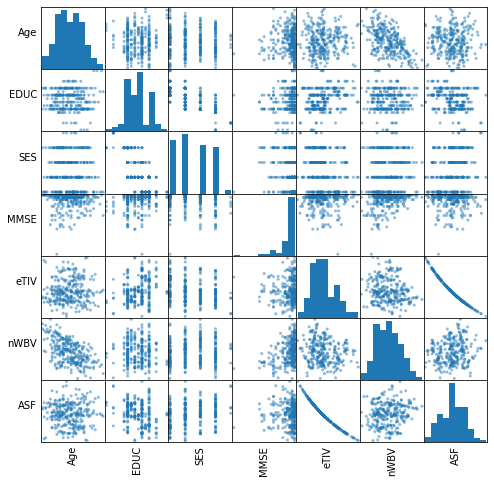

In [17]:
numeric_data = train.select([t[0] for t in train.dtypes if t[1] == 'double' or 'int']).toPandas()
num_vars = numeric_data.drop(columns = ['Group','M/F'])
axs = scatter_matrix(num_vars, figsize=(8, 8));

# Rotate axis labels and remove axis ticks
n = len(num_vars.columns)
for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())

ASF and eTIV are HIGHLY correlated as we see via the biplot scatter. They are negatively correlated.

We also get a good visual of EDUC and SES really being ordinal data types. 

MMSE is highly skewed as we see in the middle of this graphic.

The other predictors are actually fairly normally distributed!

Let's look at some of the categorical variables.

In [18]:
train_ps = ps.DataFrame(train)
train_ps.head()

,Group,M/F,Age,EDUC,SES,MMSE,eTIV,nWBV,ASF
0,0,0,64,16,3,29.0,1316,0.796,1.333
1,0,0,78,16,2,29.0,1333,0.748,1.316
2,0,0,80,16,2,29.0,1323,0.738,1.326
3,0,0,81,12,4,30.0,1230,0.715,1.427
4,0,0,83,16,2,29.0,1323,0.718,1.327


<AxesSubplot:xlabel='M/F'>

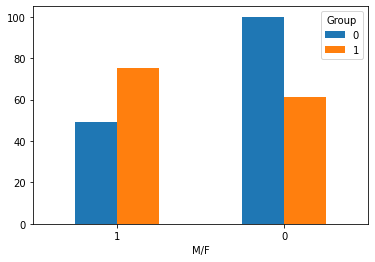

In [19]:
train_ps.groupby(['Group', 'M/F']).size().to_frame('number').reset_index().pivot('M/F', 'Group', 'number').plot(kind = 'bar', rot = 0)

In [20]:
# lets see the summary of categorical columns
train_ps.describe()

,Group,M/F,Age,EDUC,SES,MMSE,eTIV,nWBV,ASF
count,285.000000,285.000000,285.000000,285.000000,285.000000,285.000000,285.000000,285.000000,285.000000
mean,0.477193,0.435088,76.968421,14.743860,2.470175,27.417544,1489.277193,0.730470,1.194242
std,0.500358,0.496641,7.874615,2.905981,1.142946,3.652759,175.820082,0.037336,0.135744
min,0.000000,0.000000,60.000000,6.000000,1.000000,4.000000,1106.000000,0.644000,0.876000
25%,0.000000,0.000000,71.000000,12.000000,1.000000,27.000000,1353.000000,0.700000,1.104000
50%,0.000000,0.000000,77.000000,15.000000,2.000000,29.000000,1466.000000,0.731000,1.197000
75%,1.000000,1.000000,83.000000,17.000000,3.000000,30.000000,1590.000000,0.757000,1.297000
max,1.000000,1.000000,98.000000,23.000000,5.000000,30.000000,2004.000000,0.837000,1.587000


#### BIVARIATE EDA BASED ON OUR TARGET

Please note that we have EDA using `pyspark` AND `pandas`. The `pyspark` visualization capabilities are limited and we wanted to ensure that we demonstrated our ability to think through EDA and display necessary explorations the models to follow.

In [21]:
#pandas conversion for supplementary EDA
train_pd = train.toPandas()

train_pd.head()

,Group,M/F,Age,EDUC,SES,MMSE,eTIV,nWBV,ASF
0,0,0,64,16,3,29.0,1316,0.796,1.333
1,0,0,78,16,2,29.0,1333,0.748,1.316
2,0,0,80,16,2,29.0,1323,0.738,1.326
3,0,0,81,12,4,30.0,1230,0.715,1.427
4,0,0,83,16,2,29.0,1323,0.718,1.327


In [22]:
#defining a UDF for pyspark plotting!
def univar_plot(var, bin_num = 30):
    fig, ax = plt.subplots()
    hist(ax, [train.select(var).filter('Group = 1'), train.select(var).filter('Group = 0')], bins = bin_num, color = ['orange' , 'blue'])
    
    #setting up labeling
    colors = ["orange", "blue"]
    handles = [Rectangle((0, 0), 1, 1, color=c, ec="k") for c in colors]
    labels = ['Group = 1', 'Group = 0']
    ax.legend(handles, labels)


First we show the `pyspark` histogram 

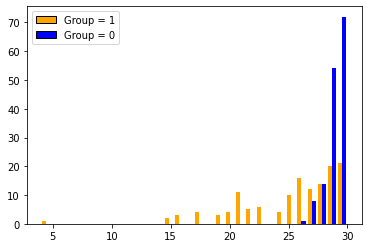

In [23]:
univar_plot('MMSE')

Now we show the distribution plot by grouping through `seaborn`. We will follow this format for a few more visualizations: pyspark hist and then seaborn dist.

In [24]:
# Plotting distributions through seaborn
def univariate_mul(var):
    sns.displot(data=train_pd, x=var, hue='Group', kind='kde', fill=True, palette=sns.color_palette('bright')[:2], height=5, aspect=1.5)

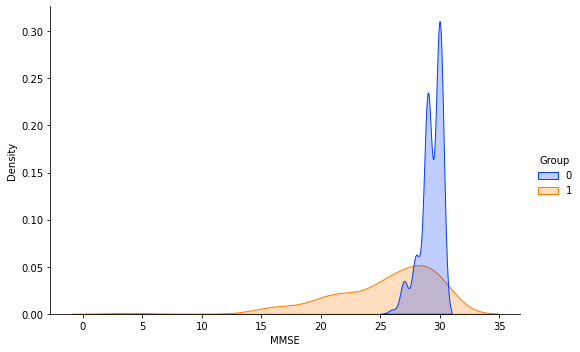

In [25]:
univariate_mul('MMSE')

Based on this, MMSE is very heavily skewed. We see a lot of larger values with a heavy left tail.
Group = 0 is nondemented and has a much higher density of MMSE scores than the Demented group. 

Recall, MMSE is a measurement of cognitive ability - so this makes sense.
****************************
Now we look into eTIV.

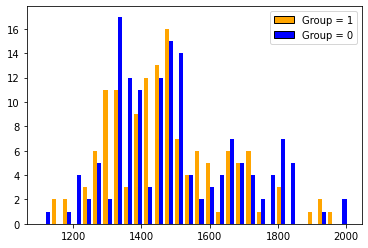

In [26]:
univar_plot('eTIV')

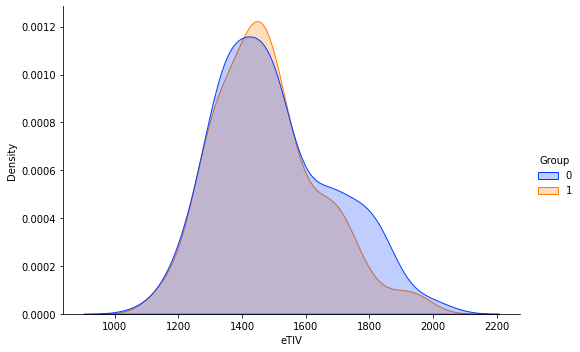

In [27]:
univariate_mul('eTIV')

Fairly normally distributed and not a large visible difference.
******************
Now ASF. Remember we saw the ASF and eTIV we highly negatively correlated in the pairs plot.

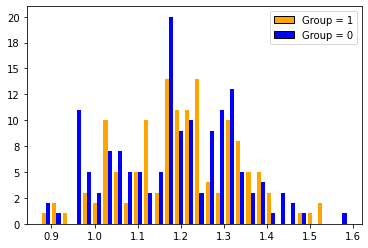

In [28]:
univar_plot('ASF')

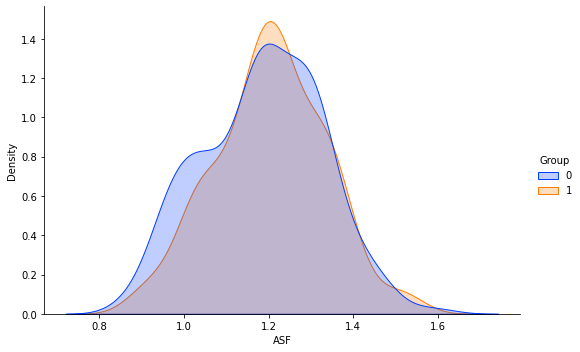

In [29]:
univariate_mul('ASF')

Fairly normal & not a large visible difference.
********************
Now nWBV

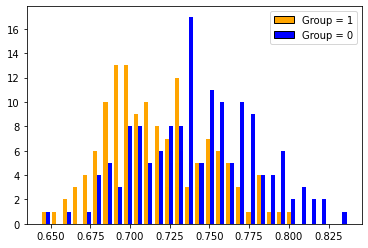

In [39]:
univar_plot('nWBV')

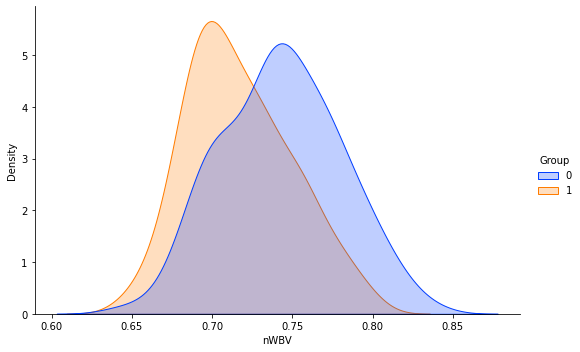

In [75]:
univariate_mul('nWBV')

Also, fairly normal & not a large difference.
******************
******************
Now we will look at some counts using our pandas-on-spark df.

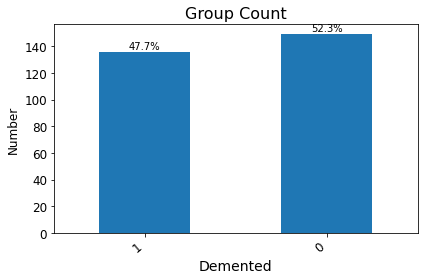

In [287]:
import matplotlib.pyplot as plt
ax = train_ps.groupby('Group').size().plot.bar(x = 'Group', title = 'Group Count')
plt.xticks(size=12)
plt.xlabel('Demented', size=14)
plt.yticks(size=12)
plt.ylabel('Number', size=12)
plt.title("Group Count", size=16)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")

total = len(train_pd)
for p in ax.patches:
    percentage = f'{100 * p.get_height() / total:.1f}%\n'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='center')
plt.tight_layout()
plt.show()

As we can see from the above plot, there are around 47.7% demented cases in the training dataset i.e., majority of the data is of Non Demented.
So lets analyze numerical features and perform univariate analysis on those features to see if we find any pattern or some interesting insights.

The problem with this variable, is that it lacks information. Converted just tells us that a person's MRI now classified someone as being Demented, but we cannot see the "progression" or severity of dementia. 

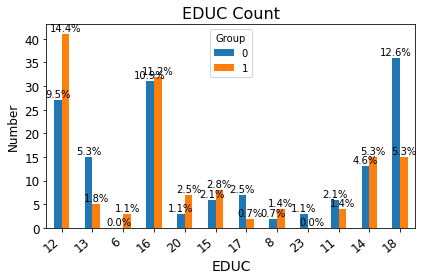

In [30]:
import matplotlib.pyplot as plt
ax = train_ps.groupby(['EDUC', 'Group']).size().to_frame('number').reset_index().sort_values('EDUC').pivot('EDUC', 'Group', 'number').plot(kind = 'bar')
plt.xticks(size=12)
plt.xlabel('EDUC', size=14)
plt.yticks(size=12)
plt.ylabel('Number', size=12)
plt.title("EDUC Count", size=16)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")

total = len(train_pd)
for p in ax.patches:
    percentage = f'{100 * p.get_height() / total:.1f}%\n'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='center')
plt.tight_layout()
plt.show()

We see more have 12 years of education (high school education). More of the demented cases seem to end with 12 years of education. When we get up to 18 years of education, we see that the Nondemented individuals take over.

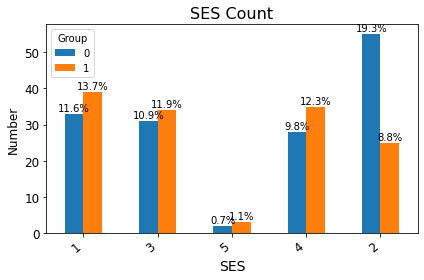

In [31]:
import matplotlib.pyplot as plt
ax = train_ps.groupby(['SES', 'Group']).size().to_frame('number').reset_index().sort_values('SES').pivot('SES', 'Group', 'number').plot(kind = 'bar')
plt.xticks(size=12)
plt.xlabel('SES', size=14)
plt.yticks(size=12)
plt.ylabel('Number', size=12)
plt.title("SES Count", size=16)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")

total = len(train_pd)
for p in ax.patches:
    percentage = f'{100 * p.get_height() / total:.1f}%\n'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='center')
plt.tight_layout()
plt.show()

SMALLER SES = HIGHER SES. Hard to interpret these results.

Now let's look at EDUC and SES a little more.

First we provide a scatter plot of EDUC and SES using our spark df.

Then to plot a fitted line we actually have to use some pandas capabilities - so we provide that below the first graph with the fitted line.

Text(0, 0.5, 'Social Economic Status(SES)')

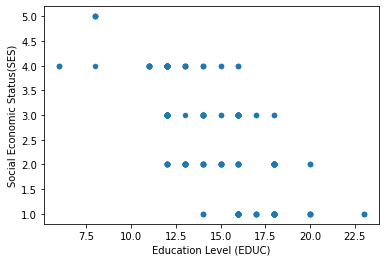

In [32]:
ps.DataFrame(train.select(col('EDUC'), col('SES'))).plot.scatter(x = 'EDUC', y = 'SES')
plt.xlabel('Education Level (EDUC)')
plt.ylabel('Social Economic Status(SES)')

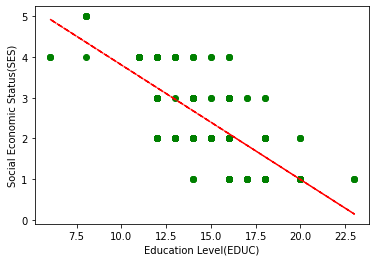

In [46]:
# Draw scatter plot between EDUC and SES
x = train_pd['EDUC']
y = train_pd['SES']

ses_not_null_index = y[~y.isnull()].index
x = x[ses_not_null_index]
y = y[ses_not_null_index]

# Draw trend line in red
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x, y, 'go', x, p(x), "r--")
plt.xlabel('Education Level(EDUC)')
plt.ylabel('Social Economic Status(SES)')

plt.show()

SES is ranked as lower number = higher status. Education increase is indicative of more education. Thus, more education does seem to suggest a higher SES standing in this cohort.

It seems as though we can maybe drop SES since there aren't major discrepencies between Nondemented and Demented individuals (besides SES =2).

### MODELS
Since we seek to predict Alzheimer's onset dementia with a categorical variable as our outcome, we will look into fitting several classification models and compare their performance utilizing a few metrics.

First we do some data pre-processing.

We already split the data into train and test.

In [36]:
#make a copy of data in case we mess up
train2 = train
test2 = test

In [37]:
#check...good
train2.show(5)

+-----+---+---+----+---+----+----+-----+-----+
|Group|M/F|Age|EDUC|SES|MMSE|eTIV| nWBV|  ASF|
+-----+---+---+----+---+----+----+-----+-----+
|    0|  0| 64|  16|  3|29.0|1316|0.796|1.333|
|    0|  0| 78|  16|  2|29.0|1333|0.748|1.316|
|    0|  0| 80|  16|  2|29.0|1323|0.738|1.326|
|    0|  0| 81|  12|  4|30.0|1230|0.715|1.427|
|    0|  0| 83|  16|  2|29.0|1323|0.718|1.327|
+-----+---+---+----+---+----+----+-----+-----+
only showing top 5 rows



Since we had to split before EDA, this makes this a little messy and non-sequeter.
We will now have to transform both the test and training data to set up the feature and labels for both. We will also have to set up the center/scale for both the train and test sets.

First let's transform and select the data we want to use.

We transform MMSE since it was heavily skewed.

In [38]:
sqlTrans = SQLTransformer(
    statement = "SELECT EDUC, Age, log(MMSE) as log_MMSE, eTIV, nWBV, ASF, Group as label FROM __THIS__"
)
#not using M/F or SES

#_THIS_ notates use the dataset that gets passed to this function.


In [39]:
features = ['Age','log_MMSE','eTIV','nWBV','ASF', 'EDUC']

Now we utilize pipelining to set up the features and labels.

In [40]:
# ASSEMBLIES WE WILL USE TO GET THE FEATURES
assembler = VectorAssembler(inputCols = features, outputCol = "features")

We could use the sqlTrans and assembler in a Pipeline, but since we could not get the transform to work in conjunction with the model fits, we run the transformations beforehand in a nested format.

We will use a Pipeline to chain multiple Transformers and Estimators together to specify our machine learning workflow. A Pipeline’s stages are specified as an ordered array.

The above code indexes each categorical column using the StringIndexer, then converts the indexed categories into one-hot encoded variables. The resulting output has the binary vectors appended to the end of each row. We use the StringIndexer again to encode our labels to label indices. Next, we use the VectorAssembler to combine all the feature columns into a single vector column.

Our target is Group and is called 'label'.

All features including the categorical are in 'features.'

In [41]:
from pyspark.ml.feature import StandardScaler

scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures",
                        withStd=True, withMean=False)

We will set up the "set-up Pipeline." We could include this in one massive pipeline for each model we consider, but the StandardScaler did not cooperate and it is important to center/scale the data. Thus, we did not want to risk not having properly formatted data for the classification models we consider.

In [42]:
set_pipe = Pipeline(stages = [sqlTrans, assembler, scaler])

In [43]:
piped = set_pipe.fit(train2)

trained = piped.transform(train2)

In [44]:
#checking...good!!!
trained.show(5)

+----+---+------------------+----+-----+-----+-----+--------------------+--------------------+
|EDUC|Age|          log_MMSE|eTIV| nWBV|  ASF|label|            features|      scaledFeatures|
+----+---+------------------+----+-----+-----+-----+--------------------+--------------------+
|  16| 64| 3.367295829986474|1316|0.796|1.333|    0|[64.0,3.367295829...|[8.12738138432202...|
|  16| 78| 3.367295829986474|1333|0.748|1.316|    0|[78.0,3.367295829...|[9.90524606214246...|
|  16| 80| 3.367295829986474|1323|0.738|1.326|    0|[80.0,3.367295829...|[10.1592267304025...|
|  12| 81|3.4011973816621555|1230|0.715|1.427|    0|[81.0,3.401197381...|[10.2862170645325...|
|  16| 83| 3.367295829986474|1323|0.718|1.327|    0|[83.0,3.367295829...|[10.5401977327926...|
+----+---+------------------+----+-----+-----+-----+--------------------+--------------------+
only showing top 5 rows



We repeat for the test data.

In [45]:
piped = set_pipe.fit(test2)

tested = piped.transform(test2)

### Classification Pipeline

Now we work to set up the Classification Models!

We choose to use PCA as a step in the pipeline to select features which explain variability in the data.

We won't use this for k-NN as this is a clustering method...but for the tree methods, we try to reduce the predictor space to a list of orthogonal components which explain the most variability in the data. We use these uncorrelated PC's as a way to handle some of the correlation present in the data. The only downside is that we lose some of the interpretability of the features which are selected as 'important' to the models.

In [47]:
#set up PCA
pca_model = PCA(inputCol = "scaledFeatures", outputCol = "pca_features_cv")

We set up the pyspark.ml classifiers here.

In [48]:
#set up random forest
rf = RandomForestClassifier(labelCol = "label", featuresCol = "pca_features_cv")

#set up decision tree
dt = DecisionTreeClassifier(labelCol = "label", featuresCol = 'pca_features_cv')

#set up k-nn
knn = KMeans(maxIter = 50)

#set up xgboost
gbt = GBTClassifier(maxIter=50)

Now we set up the pipelines for all of the Classification Models we consider.

In [49]:
# decision tree pipeline
pipeline_dt=Pipeline(stages = [pca_model, dt])

# random forest pipeline
pipeline_rf = Pipeline(stages = [pca_model, rf])

# k-nn pipeline
pipeline_kn=Pipeline(stages = [knn]) #we omit the pca step for this  model

# xgboost pipeline
pipeline_xgb=Pipeline(stages = [gbt])

### DECISION TREE MODEL

A Decision Tree is a tree-like graph where sorting starts from the root node to the leaf node until the target is achieved. It is the most popular one for decision and classification based on supervised algorithms. It is constructed by recursive partitioning where each node acts as a test case for some attributes and each edge, deriving from the node, is a possible answer in the test case. Both the root and leaf nodes are two entities of the algorithm. This is a SUPERVISED MACHINE LEARNING technique (i.e. it will consider 'label' when splitting by the 'features' we supply). [[learn more here]](https://www.javatpoint.com/machine-learning-decision-tree-classification-algorithm)


In [50]:
paramGrid_dt = ParamGridBuilder() \
    .addGrid(pca_model.k, [2,3,4,5,6]) \
    .addGrid(dt.maxDepth, [2,3,4,5,6]) \
    .addGrid(dt.minInstancesPerNode, [10,15,20,25]) \
    .build()

crossval_dt = CrossValidator(estimator = pipeline_dt,
                            estimatorParamMaps=paramGrid_dt,
                            evaluator = BinaryClassificationEvaluator(labelCol = "label"),
                            numFolds= 5) #5 fold CV

cv_dt = crossval_dt.fit(trained)

In [51]:
predictions = cv_dt.transform(tested)
evaluator= BinaryClassificationEvaluator(labelCol = "label", rawPredictionCol="probability", metricName= "areaUnderROC")
performance_dt = evaluator.evaluate(predictions)

print(performance_dt)

0.5317944250871081


This evaluator calculates the area under the ROC. This is a metric that combines the two kinds of errors a binary classifier can make (false positives and false negatives) into a simple number.

We see here that our Decision Tree Model did really quite poorly. 
Area under the ROC closer to 1 is almost a perfect predictor. If is it less than 0.5, then we essentially have a model that performance worse than a coin flip.

In [52]:
#extract parameters
params_dt = [{p.name: v for p, v in m.items()} for m in cv_dt.getEstimatorParamMaps()]

dt_results = pd.DataFrame.from_dict([
    {cv_dt.getEvaluator().getMetricName(): metric, **ps} 
    for ps, metric in zip(params_dt, cv_dt.avgMetrics)
])

dt_results.sort_values(by = 'areaUnderROC', ascending = False)

,areaUnderROC,k,maxDepth,minInstancesPerNode
56,0.766856,4,6,10
76,0.764238,5,6,10
96,0.759439,6,6,10
57,0.741393,4,6,15
36,0.729525,3,6,10
...,...,...,...,...
27,0.467186,3,3,25
4,0.463120,2,3,10
1,0.461451,2,2,15
3,0.461451,2,2,25


The results show that our Decision Tree with the best TRAINING areaUROC has 4 principal components (so we did not reduce the predictor space), a maxdepth of 6, and 10 instances per node.

Since we did not reduce the predictor space, let's remove the PCA step and see if we can extract the raw scaled feature importances afterwards.

In [53]:
dt2 = DecisionTreeClassifier(labelCol = "label", featuresCol = 'features')
pipeline_dt2=Pipeline(stages = [dt2])

In [54]:
paramGrid_dt2 = ParamGridBuilder() \
    .addGrid(dt.maxDepth, [2,3,4,5,6]) \
    .addGrid(dt.minInstancesPerNode, [10,15,20,25]) \
    .build()

crossval_dt2 = CrossValidator(estimator = pipeline_dt2,
                            estimatorParamMaps=paramGrid_dt2,
                            evaluator = BinaryClassificationEvaluator(labelCol = "label"),
                            numFolds= 5) #5 fold CV return features for the model

cv_dt = crossval_dt2.fit(trained)

In [55]:
predictions = cv_dt.transform(tested)
evaluator= BinaryClassificationEvaluator(labelCol = "label", rawPredictionCol="probability", metricName= "areaUnderROC")
performance_dt2 = evaluator.evaluate(predictions)

print(performance_dt2)

0.8109756097560976


This one does MUCH MUCH BETTER WITH TEST AreaUnderROC!

In [56]:
#get features
# '0' for the stage in pipeline where model fit
dt_ft = cv_dt.bestModel.stages[0] 
var_imp_dt = dt_ft.featureImportances

var_imp_dt

SparseVector(6, {0: 0.0866, 1: 0.7669, 2: 0.0502, 3: 0.0872, 5: 0.0092})

We see that the feature that is the most important is the second element in the 'feature' vector we input.
features = ['Age','log_MMSE','eTIV','nWBV','ASF', 'EDUC']

So, log(MMSE) is the most important. We actually see that ASF (the 5th element...or index 4) does not even appear in the feature importance list!

### RANDOM FOREST MODEL

To begin, a random forest is a compilation of many trees. Trees are simply an easy to interpret visualization method of how to split up the data into multiple categories. The process of forming a tree is simple
- divide the predictor space into J distinct and non-overlapping regions, R_1,...,R_J 
- For every observation that falls into the region R_j, we make the same prediction.

The algorithm for building the trees is greedy. This means that at each step in splitting the tree, we take the best possible situation at each step rather than going through all possible splits to find the overall optimum result.

What determines the best possible situation? Rather than trying to minimize mean squared error (as is the case for continuous data),  we wish to minimize classification error rate. Classification trees predict using whatever response is most common in the leaf, R_j. Therefore, classification error rate refers to the fraction of outcomes in the leaf that are not the most common response category. The best way of measuring this error is with a form of the Gini Index known as entropy.

Another way to think about RF is:
Assuming your dataset has “m” features, the random forest will randomly choose “k” features where k < m.  Now, the algorithm will calculate the root node among the k features by picking a node that has the highest information gain. 

After that, the algorithm splits the node into child nodes and repeats this process “n” times. Now you have a forest with n trees. Finally, you’ll perform bootstrapping, i.e., combine the results of all the decision trees present in your forest.

It is certainly one of the most sophisticated algorithms as it builds on the functionality of decision trees. 

Technically, it is an ensemble algorithm. The algorithm generates the individual decision trees through an attribute selection indication. Every tree relies on an independent random sample. In a classification problem, every tree votes and the most popular class is the end result. 

In [57]:
paramGrid_rf = ParamGridBuilder() \
      .addGrid(pca_model.k, [1,2,3,4,5,6]) \
      .addGrid(rf.numTrees, [5,10,15,20]) \
      .build()

crossval_rf = CrossValidator(estimator = pipeline_rf,
                            estimatorParamMaps=paramGrid_rf,
                            evaluator = BinaryClassificationEvaluator(labelCol = "label"),
                            numFolds= 5)

cv_rf = crossval_rf.fit(trained)

Now we evaluate the accuracy of our Cross Validated RF model!!

In [58]:
predictions = cv_rf.transform(tested)
evaluator= BinaryClassificationEvaluator(labelCol = "label", rawPredictionCol="probability", metricName= "areaUnderROC")
performance_rf = evaluator.evaluate(predictions)

print(performance_rf)

0.6106271777003485


Our Cross Validated Random Forest model has Area under the ROC of 0.6106. This is definitely better than the Decision Tree, but still not great.

Maybe the next 2 methods will do better. But first let's look at the parameters and feature importance.

In [59]:
#extract parameters
params_rf = [{p.name: v for p, v in m.items()} for m in cv_rf.getEstimatorParamMaps()]

rf_results = pd.DataFrame.from_dict([
    {cv_rf.getEvaluator().getMetricName(): metric, **ps} 
    for ps, metric in zip(params_rf, cv_rf.avgMetrics)
])

rf_results.sort_values(by = 'areaUnderROC', ascending = False)

,areaUnderROC,k,numTrees
15,0.862883,4,20
19,0.859287,5,20
23,0.851710,6,20
18,0.847426,5,15
13,0.839324,4,10
14,0.837837,4,15
22,0.836338,6,15
16,0.833708,5,5
20,0.831281,6,5
21,0.824067,6,10


We see that the best model used 4 principal components and had a depth of 20 for the tree.

Since PCA loses the original feature names, we won't extract the feature importances in their raw format.

Let's see if some of the other methods do well.

### K-NN CLASSIFIER

The K Nearest Neighbor is another supervised algorithm that works by classifying data points using the k nearest points to it. There are different distances that can be used, but here we'll use the euclidean distance. The euclidean distance calculates the distance (d) between two points, say $(x_1, y_1)$ and $(x_2, y_2)$, on a plane using the following formula:

$$
d = \sqrt{(x_2 - x_1)^2 + (y_2 - y_1)^2}
$$

We need to find the right value for k to use, as larger k values tend to underfit and smaller k values overfit. 

In [60]:
paramGrid_kn = ParamGridBuilder() \
      .addGrid(knn.k, [5,7,9,11,13,20,25]) \
      .build()

crossval_knn = CrossValidator(estimator = pipeline_kn,
                            estimatorParamMaps=paramGrid_kn,
                            evaluator = ClusteringEvaluator(),
                            numFolds= 5)

cv_kn = crossval_knn.fit(trained)

In [61]:
#extract parameters
params_kn = [{p.name: v for p, v in m.items()} for m in cv_kn.getEstimatorParamMaps()]

kn_results = pd.DataFrame.from_dict([
    {cv_kn.getEvaluator().getMetricName(): metric, **ps} 
    for ps, metric in zip(params_kn, cv_kn.avgMetrics)
])

kn_results

,silhouette,k
0,0.705041,5
1,0.646170,7
2,0.671052,9
3,0.609744,11
4,0.635106,13
5,0.583973,20
6,0.520555,25


Higher silhouette is better. So k = 5 is being used in our trained K-Means model.

Silhouette score is used to evaluate the quality of clusters created using clustering algorithms such as K-Means in terms of how well samples are clustered with other samples that are similar to each other. The Silhouette score is calculated for each sample of different clusters. To calculate the Silhouette score for each observation/data point, the following distances need to be found out for each observations belonging to all the clusters:

Mean distance between the observation and all other data points in the same cluster. This distance can also be called a mean intra-cluster distance. The mean distance is denoted by a
Mean distance between the observation and all other data points of the next nearest cluster. This distance can also be called a mean nearest-cluster distance. The mean distance is denoted by b.

The value of the Silhouette score varies from -1 to 1. If the score is 1, the cluster is dense and well-separated than other clusters. A value near 0 represents overlapping clusters with samples very close to the decision boundary of the neighboring clusters. A negative score [-1, 0] indicates that the samples might have got assigned to the wrong clusters.

We should extract the performance on the test set.

In [62]:
predictions = cv_kn.transform(tested)
evaluator = ClusteringEvaluator(metricName= "silhouette")
performance_kn = evaluator.evaluate(predictions)

print(performance_kn)

0.6222518653045874


So our K-Means Cluster model did not do too badly.

### XGBoost CLASSIFIER

An XGBoost model is one that uses the gradient boosting decision tree algorithm and XGBoost stands for Extreme Gradient Boosting. This method works by adding weak learners, usually decision trees, using a gradient descent optimization algorithm that minimizes the loss function. One of the benefits of this model is that it performs faster than other gradient boosting techniques. It also performs well on structured datasets. The model has a regularization term that helps avoid over-fitting. 

Now let's fit and tune the parameters!

In [63]:
paramGrid_xgb = ParamGridBuilder() \
.addGrid(gbt.maxDepth, [2, 5, 10]) \
.addGrid(gbt.maxBins, [10, 20, 40]) \
.addGrid(gbt.maxIter, [5, 10, 20]) \
.build()

crossval_xgb = CrossValidator(estimator = pipeline_xgb,
                            estimatorParamMaps=paramGrid_xgb,
                            evaluator = BinaryClassificationEvaluator(labelCol = "label"),
                            numFolds= 5)

cv_xgb = crossval_xgb.fit(trained)

Now let's use this model on the test set to see how it performs.

In [64]:
predictions = cv_xgb.transform(tested)
evaluator= BinaryClassificationEvaluator(labelCol = "label", rawPredictionCol="probability", metricName= "areaUnderROC")
performance_xgb = evaluator.evaluate(predictions)

print(performance_xgb)

0.8736933797909407


The XGBoost model performed very well! Let's take a quick look at what the parameters were for the model that was chosen.

In [74]:
best_model = cv_xgb.bestModel

params_xgb = [{p.name: v for p, v in m.items()} for m in cv_xgb.getEstimatorParamMaps()]
xgb_results = pd.DataFrame.from_dict([
    {cv_xgb.getEvaluator().getMetricName(): metric, **ps} 
    for ps, metric in zip(params_xgb, cv_xgb.avgMetrics)
])

xgb_results.sort_values(by = 'areaUnderROC', ascending = False)

,areaUnderROC,maxDepth,maxBins,maxIter
5,0.861106,2,20,20
4,0.851699,2,20,10
8,0.848477,2,40,20
3,0.842333,2,20,5
7,0.840365,2,40,10
14,0.829034,5,20,20
2,0.828662,2,10,20
6,0.827178,2,40,5
13,0.822340,5,20,10
11,0.820119,5,10,20


It looks like the best parameters were a max depth of 2, max bins of 20, and a max iteration of 20.

### LOGISTIC REGRESSION 

We finally perform Logistic Regression since we have a binary outcome. The methods above give us a way of classifying MRIs into Groups of Dementia , but do not give us interpretability as it pertains to "risk factors."

So, logistic regression is performed to identify the log odds...and odds after transformation of the coefficients...associated with particular features as it pertains to having Dementia versus not.

We do not use the scaled features as a side note.

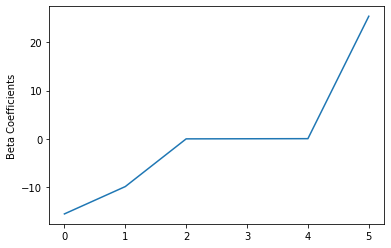

In [66]:
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)

lrModel = lr.fit(trained)

#view betas
beta = np.sort(lrModel.coefficients)
plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()

Summarize the model over the training set, we can also obtain the receiver-operating characteristic and areaUnderROC.

c:\users\genel\appdata\local\programs\python\python39\lib\site-packages\pyspark\sql\context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


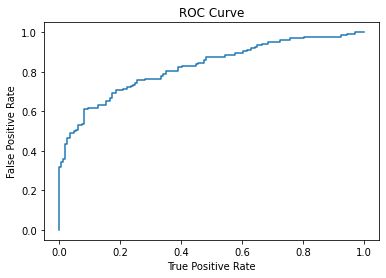

Training set areaUnderROC: 0.8249111725227004


In [68]:
training_summary = lrModel.summary
roc = ps.DataFrame(training_summary.roc)
roc.plot(x = 'FPR', y = 'TPR', legend = None)
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(training_summary.areaUnderROC))

The AUROC is actually pretty good on the training data = .82.

Precision & Recall

c:\users\genel\appdata\local\programs\python\python39\lib\site-packages\pyspark\sql\context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


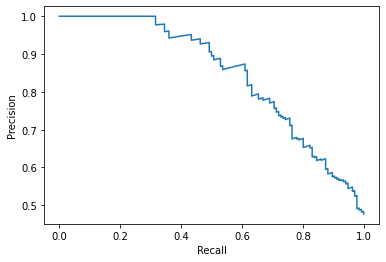

In [69]:
pr = ps.DataFrame(training_summary.pr)
pr.plot(x = 'recall', y = 'precision', legend = None)
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

Now let's evaluate on the test data!

In [70]:
predictions = lrModel.transform(tested)
predictions.select('features', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

+--------------------+-----+--------------------+----------+--------------------+
|            features|label|       rawPrediction|prediction|         probability|
+--------------------+-----+--------------------+----------+--------------------+
|[61.0,3.401197381...|    0|[1.68302642144930...|       0.0|[0.84330486343766...|
|[82.0,3.401197381...|    0|[-0.0740705074555...|       1.0|[0.48149083481454...|
|[85.0,3.401197381...|    0|[0.78710568129098...|       0.0|[0.68720952662580...|
|[68.0,3.295836866...|    1|[0.53668697126724...|       0.0|[0.63104138681258...|
|[72.0,3.258096538...|    1|[-2.2648275811765...|       1.0|[0.09407811957606...|
|[82.0,3.332204510...|    1|[-0.0182957389352...|       1.0|[0.49542619284957...|
|[88.0,3.218875824...|    1|[-2.3171986817634...|       1.0|[0.08970855481372...|
|[69.0,3.367295829...|    0|[1.14945950177046...|       0.0|[0.75941217889299...|
|[80.0,3.401197381...|    0|[1.31995582351063...|       0.0|[0.78917435661174...|
|[73.0,3.3322045

Now let's get the AUROC for the predictions on the test set. We do this so we can compare the Logistic Regression model to the other models performances.

In [71]:
evaluator = BinaryClassificationEvaluator()
print('Test Area Under ROC', evaluator.evaluate(predictions))

Test Area Under ROC 0.7987804878048781


This isn't terrible.

Let's go back and get the coefficients.

In [72]:
lrModel.coefficients

DenseVector([-0.0017, -15.5787, 0.0194, -9.9104, 25.3938, -0.0221])

Recall our features were sorted as : features = ['Age','log_MMSE','eTIV','nWBV','ASF', 'EDUC']

Thus we interpret these results as:
- For a one unit increase in Age, one's log odds of having Dementia decreases by .0017.
- For a one unit increase in log(MMSE), one's log odds of having Dementia decreases by 15.58.
- For a one unit increase in eTIV, one's log odds of having Dementia increases by .02
- For a one unit increase in nWBV (brain volume), one's log odds of having Dementia decreases by 9.9
- For a one unit increase in ASF, one's log odds of having Dementia increases by 25.
- For a one unit increase in EDUC (years of education), one's log odds of having Dementia decreases by .02.

Some of these results do not seem to make much sense, but we provide those interpretations anyway.

### RESULTS

We saw how each of the models performed individually, but let's put it all together to view them in one place.

In [73]:
results = {'models': ['Decision Tree with PCA', 'Decision Tree no PCA', 'Random Forest', 'K-NN', 'XGBoost'],
           'performance': [performance_dt, performance_dt2, performance_rf, performance_kn, performance_xgb]}

ps.DataFrame(results)

,models,performance
0,Decision Tree with PCA,0.531794
1,Decision Tree no PCA,0.810976
2,Random Forest,0.610627
3,K-NN,0.622252
4,XGBoost,0.873693


We can see that the XGBoost model performed the best out of the selected models. There was also a significant increase in the decision tree performance when we didn't use PCA. 

A random forest model is known to perform well and is a popular choice in machine learning, so it's a little surprising to see this wasn't one of the top performers. 

### DISCUSSION & CONCLUDING THOUGHTS

Our goal with this was to find a way to determine whether someone was categorized as demented or not based on different factors from the data provided. 

From our exploratory analysis, we saw that age seemed to have a relationship with being demented, as higher educated people were less demented  compared to lower educated people. 

We decided to use Age, MMSE, eTIV, nWBV, ASF, EDUC as the features in our model. 

We looked at a few different classification models, and saw that an XGBoost model performed the best in prediction. 

From the decision tree, we saw that log(MMSE) was the most important predictor from the features that we used.

***********************
************************
END OF ASSIGNMENT.
************************
************************